In [1]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np

import catboost as cb

from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

import datetime
from datetime import datetime, date

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
data = pd.read_csv('preprocessed_data.csv')
df_train = pd.read_csv('assignment_2_train.csv')

In [3]:
data.head(2)

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,card5_transform,card6_transform,addr1_transform,addr2_transform,card1_card2_transform,card1_card2_card3_card5_transform,card1_card2_card3_card5_addr1_addr2_transform,TransactionAmt_integer,TransactionAmt_fractional,TransactionAmt_log
0,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,...,142.176613,171.249895,194.069187,186.33749,0.577350,0.577350,NaN,68,0.5,4.226834
1,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,...,171.390409,171.249895,194.440057,186.33749,177.751006,177.751006,123.056897,29,0.0,3.367296


In [4]:
data.shape

(180000, 419)

In [5]:
target = df_train['isFraud']

**Задание 0:** выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.

In [6]:
categorical_features = data.select_dtypes(include=[np.object])
print(f'Всего категориальных признаков {categorical_features.shape[1]}')
# categorical_features = categorical_features.columns.tolist()

Всего категориальных признаков 17


In [7]:
for col in categorical_features:
    data[col] = data[col].astype(str)

In [8]:
x_train, x_valid, y_train, y_valid = train_test_split(
    data, target, train_size=0.7, shuffle=True, random_state=1,
)

In [9]:
train_pool = cb.Pool(x_train, y_train, cat_features=categorical_features)
valid_pool = cb.Pool(x_valid, y_valid, cat_features=categorical_features)

In [10]:
cb_params = {
#     "n_estimators": 3000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 100,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 100,
    "thread_count": 6,
    "random_seed": 42,
    "cat_features":categorical_features
}

model = cb.CatBoostClassifier(**cb_params)
fit_model = model.fit(train_pool, eval_set=[(train_pool), (valid_pool)])

0:	test: 0.5001379	test1: 0.5000000	best: 0.5000000 (0)	total: 167ms	remaining: 2m 46s
100:	test: 0.9569761	test1: 0.9109803	best: 0.9109803 (100)	total: 28.2s	remaining: 4m 10s
200:	test: 0.9728111	test1: 0.9249282	best: 0.9249939 (199)	total: 59.3s	remaining: 3m 55s
300:	test: 0.9777191	test1: 0.9308089	best: 0.9308089 (300)	total: 1m 30s	remaining: 3m 29s
400:	test: 0.9791938	test1: 0.9333409	best: 0.9333409 (400)	total: 2m	remaining: 2m 59s
500:	test: 0.9801371	test1: 0.9355827	best: 0.9356290 (496)	total: 2m 30s	remaining: 2m 29s
600:	test: 0.9811286	test1: 0.9365814	best: 0.9365815 (598)	total: 2m 58s	remaining: 1m 58s
700:	test: 0.9811808	test1: 0.9366084	best: 0.9366117 (618)	total: 3m 26s	remaining: 1m 28s
800:	test: 0.9812225	test1: 0.9366115	best: 0.9366488 (763)	total: 3m 53s	remaining: 58.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9366487611
bestIteration = 763

Shrink model to first 764 iterations.


**Задание 1:** использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

In [11]:
feature_importances = model.get_feature_importance(data=train_pool,
                       prettified=False,
                       thread_count=-1,
                       verbose=False)

In [12]:
# feature_importances = fit_model.feature_importances_

In [13]:
feature_importances_flatten = []
for i in range(len(feature_importances)):
    col = (data.columns[i], feature_importances[i])
    feature_importances_flatten.append(col)
feat_importances = pd.DataFrame(feature_importances_flatten, columns=['feature','importance'])

feat_importances = feat_importances.sort_values(by='importance', ascending=False)

Text(0.5, 1.0, 'Feature Importances')

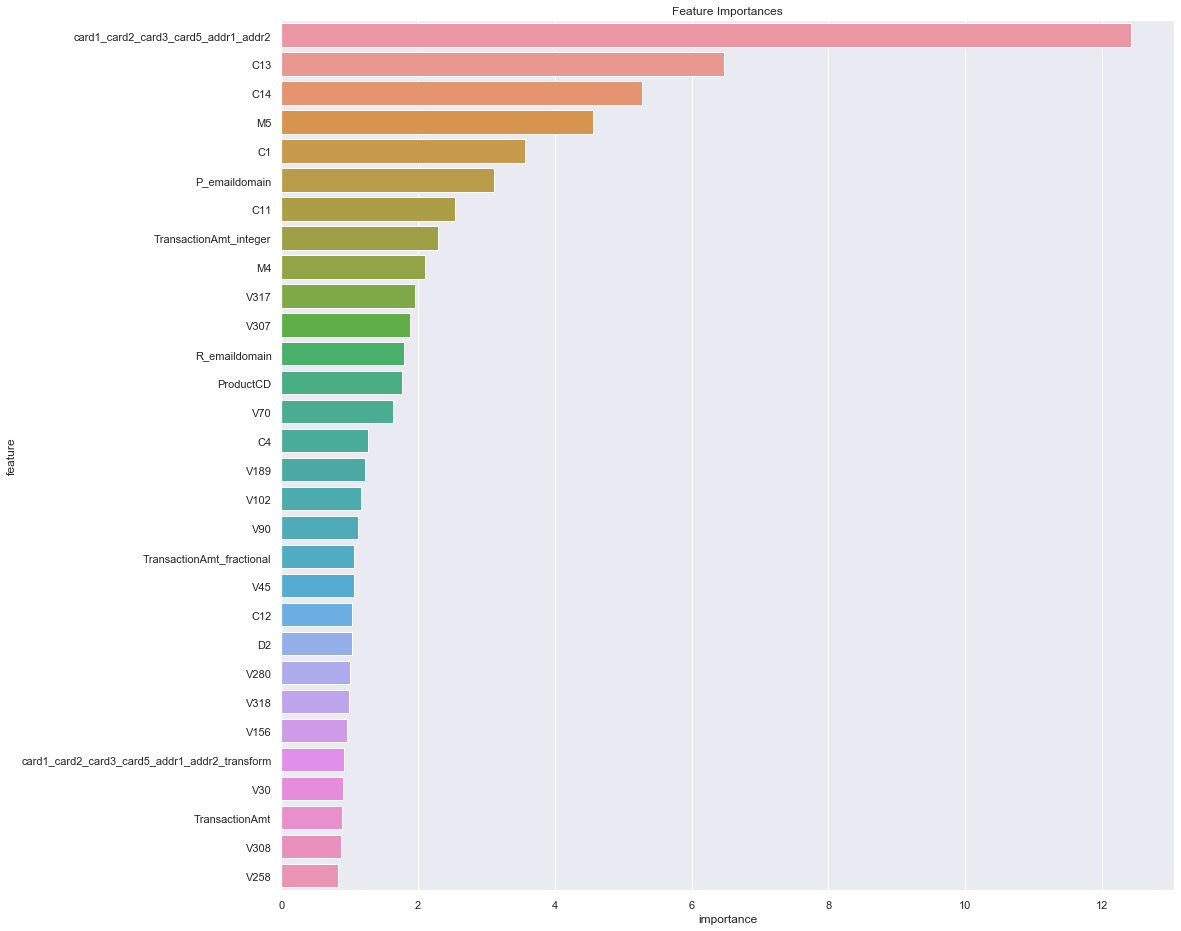

In [14]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feat_importances[:30], x='importance', y='feature')
plt.title('Feature Importances')

**Задание 2:** удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

In [15]:
features_to_drop = feat_importances.loc[feat_importances['importance']<0.1, 'feature'].tolist()

In [16]:
x_train.drop(features_to_drop, axis=1, inplace=True)
x_valid.drop(features_to_drop, axis=1, inplace=True)

In [17]:
categorical_features = x_train.select_dtypes(include=[np.object])
print(f'Всего категориальных признаков {categorical_features.shape[1]}')
# categorical_features = categorical_features.columns.tolist()

Всего категориальных признаков 11


In [18]:
train_pool = cb.Pool(x_train, y_train, cat_features=categorical_features)
valid_pool = cb.Pool(x_valid, y_valid, cat_features=categorical_features)

In [19]:
cb_params = {
#     "n_estimators": 3000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 100,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 100,
    "thread_count": 6,
    "random_seed": 42,
    "cat_features":categorical_features
}


In [20]:
model = cb.CatBoostClassifier(**cb_params)
fit_model = model.fit(train_pool, eval_set=[(train_pool), (valid_pool)])

0:	test: 0.7318274	test1: 0.7303628	best: 0.7303628 (0)	total: 216ms	remaining: 3m 36s
100:	test: 0.9551051	test1: 0.9113866	best: 0.9114099 (98)	total: 17.4s	remaining: 2m 34s
200:	test: 0.9678005	test1: 0.9235955	best: 0.9236404 (199)	total: 36.7s	remaining: 2m 25s
300:	test: 0.9733932	test1: 0.9309982	best: 0.9309983 (299)	total: 56.2s	remaining: 2m 10s
400:	test: 0.9759859	test1: 0.9339791	best: 0.9339791 (400)	total: 1m 15s	remaining: 1m 53s
500:	test: 0.9785972	test1: 0.9365580	best: 0.9365582 (499)	total: 1m 35s	remaining: 1m 35s
600:	test: 0.9787368	test1: 0.9366226	best: 0.9366473 (583)	total: 1m 52s	remaining: 1m 14s
700:	test: 0.9788225	test1: 0.9366864	best: 0.9366864 (697)	total: 2m 9s	remaining: 55.3s
800:	test: 0.9791082	test1: 0.9368673	best: 0.9368674 (795)	total: 2m 26s	remaining: 36.5s
900:	test: 0.9791902	test1: 0.9369257	best: 0.9369280 (893)	total: 2m 44s	remaining: 18s
999:	test: 0.9792393	test1: 0.9369712	best: 0.9369717 (993)	total: 3m 1s	remaining: 0us

bestTe

**Вывод** модель улучшена на 0,0003 на валидации

**Задание 3:** использовать permutation importance, выполнить задание 1 и 2.

In [21]:
from sklearn.inspection import permutation_importance

importance = permutation_importance(
    model, x_valid, y_valid, scoring="roc_auc", n_jobs=6, random_state=27
)

In [22]:
importance_scores = pd.DataFrame({
    "features": x_valid.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)
decrease_scores = importance_scores[importance_scores["importance-mean"]<=0]
decrease_scores = decrease_scores.reset_index(drop=True)

In [23]:
to_drop = decrease_scores['features'].tolist()

In [24]:
x_train.drop(to_drop, axis=1, inplace=True)
x_valid.drop(to_drop, axis=1, inplace=True)

In [25]:
categorical_features = x_train.select_dtypes(include=[np.object])
print(f'Всего категориальных признаков {categorical_features.shape[1]}')
# categorical_features = categorical_features.columns.tolist()

Всего категориальных признаков 9


In [26]:
train_pool = cb.Pool(x_train, y_train, cat_features=categorical_features)
valid_pool = cb.Pool(x_valid, y_valid, cat_features=categorical_features)

In [27]:
cb_params = {
#     "n_estimators": 3000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 100,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 100,
    "thread_count": 6,
    "random_seed": 42,
    "cat_features":categorical_features
}


In [28]:
model = cb.CatBoostClassifier(**cb_params)
fit_model = model.fit(train_pool, eval_set=[(train_pool), (valid_pool)])

0:	test: 0.6834921	test1: 0.6871362	best: 0.6871362 (0)	total: 193ms	remaining: 3m 13s
100:	test: 0.9581709	test1: 0.9145415	best: 0.9145415 (100)	total: 15.6s	remaining: 2m 19s
200:	test: 0.9719957	test1: 0.9254728	best: 0.9254728 (200)	total: 33.5s	remaining: 2m 13s
300:	test: 0.9786231	test1: 0.9334721	best: 0.9334721 (300)	total: 51.9s	remaining: 2m
400:	test: 0.9811388	test1: 0.9380921	best: 0.9380921 (400)	total: 1m 9s	remaining: 1m 44s
500:	test: 0.9813483	test1: 0.9385749	best: 0.9385805 (462)	total: 1m 25s	remaining: 1m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9385805167
bestIteration = 462

Shrink model to first 463 iterations.


**Вывод** Достигнуто улучшение модели на валидационном наборе в 0,002

**Задание 5:** использовать shap, выполнить задание 1 и 2.

In [29]:
import shap

In [30]:
model = cb.CatBoostClassifier(**cb_params)
fit_model = model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)])

0:	test: 0.6834921	test1: 0.6871362	best: 0.6871362 (0)	total: 223ms	remaining: 3m 42s
100:	test: 0.9581709	test1: 0.9145415	best: 0.9145415 (100)	total: 16.2s	remaining: 2m 24s
200:	test: 0.9719957	test1: 0.9254728	best: 0.9254728 (200)	total: 35s	remaining: 2m 19s
300:	test: 0.9786231	test1: 0.9334721	best: 0.9334721 (300)	total: 54.2s	remaining: 2m 5s
400:	test: 0.9811388	test1: 0.9380921	best: 0.9380921 (400)	total: 1m 11s	remaining: 1m 47s
500:	test: 0.9813483	test1: 0.9385749	best: 0.9385805 (462)	total: 1m 27s	remaining: 1m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9385805167
bestIteration = 462

Shrink model to first 463 iterations.


In [31]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid, y_valid)

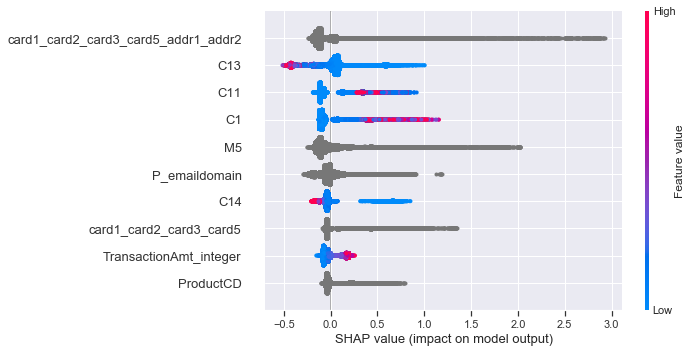

In [32]:
shap.summary_plot(shap_values, x_valid, max_display=10)

In [33]:
shap_feature_importance = pd.DataFrame(list(zip(x_valid.columns, np.abs(shap_values).mean(0))),columns=['feature','shap_values'])
shap_feature_importance.sort_values(by=['shap_values'],ascending=False,inplace=True)

shap_feature_importance.head(10)

,feature,shap_values
82,card1_card2_card3_card5_addr1_addr2,0.175425
12,C13,0.148940
10,C11,0.148398
7,C1,0.144844
23,M5,0.142153
5,P_emaildomain,0.096180
13,C14,0.090448
81,card1_card2_card3_card5,0.079464
85,TransactionAmt_integer,0.078864
1,ProductCD,0.063214


In [35]:
features_to_drop = shap_feature_importance[50:]

In [36]:
to_drop = features_to_drop['feature'].tolist()

In [37]:
x_train.drop(to_drop, axis=1, inplace=True)

x_valid.drop(to_drop, axis=1, inplace=True)

In [38]:
categorical_features = x_train.select_dtypes(include=[np.object])
print(f'Всего категориальных признаков {categorical_features.shape[1]}')
# categorical_features = categorical_features.columns.tolist()

Всего категориальных признаков 8


In [39]:
train_pool = cb.Pool(x_train, y_train, cat_features=categorical_features)
valid_pool = cb.Pool(x_valid, y_valid, cat_features=categorical_features)

In [40]:
cb_params = {
#     "n_estimators": 3000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 100,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 100,
    "thread_count": 6,
    "random_seed": 42,
    "cat_features":categorical_features
}


In [41]:
model = cb.CatBoostClassifier(**cb_params)
fit_model = model.fit(train_pool, eval_set=[(train_pool), (valid_pool)])

0:	test: 0.6181467	test1: 0.6201661	best: 0.6201661 (0)	total: 70.6ms	remaining: 1m 10s
100:	test: 0.9601639	test1: 0.9147689	best: 0.9147689 (100)	total: 13.1s	remaining: 1m 56s
200:	test: 0.9759999	test1: 0.9296254	best: 0.9296254 (200)	total: 28.4s	remaining: 1m 52s
300:	test: 0.9794595	test1: 0.9357764	best: 0.9357764 (300)	total: 44.2s	remaining: 1m 42s
400:	test: 0.9812409	test1: 0.9389924	best: 0.9389924 (400)	total: 59.5s	remaining: 1m 28s
500:	test: 0.9819089	test1: 0.9402378	best: 0.9402463 (498)	total: 1m 13s	remaining: 1m 12s
600:	test: 0.9827360	test1: 0.9413874	best: 0.9413907 (597)	total: 1m 25s	remaining: 56.6s
700:	test: 0.9830723	test1: 0.9421301	best: 0.9421301 (698)	total: 1m 38s	remaining: 41.8s
800:	test: 0.9835283	test1: 0.9428732	best: 0.9428732 (800)	total: 1m 50s	remaining: 27.4s
900:	test: 0.9837862	test1: 0.9433165	best: 0.9433172 (899)	total: 2m 3s	remaining: 13.6s
999:	test: 0.9839206	test1: 0.9437121	best: 0.9437158 (980)	total: 2m 14s	remaining: 0us

bes

**Вывод** модель улучшена на 0,0052 на валидации

**Задание 6:** построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

In [42]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid, y_valid)

In [45]:
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = x_valid.iloc[select]
features_display = x_valid.loc[features.index]
shap_values = explainer.shap_values(features)


Explainer expected value: -4.814995795823566


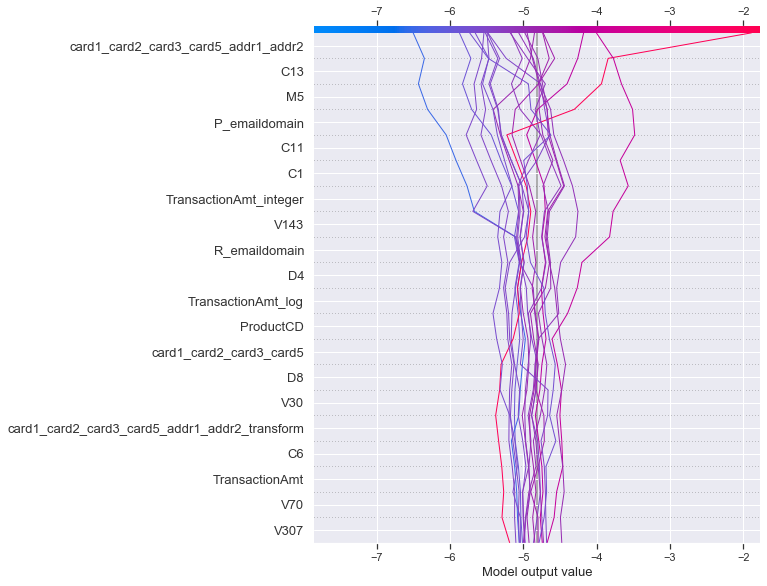

In [46]:
shap.decision_plot(
    expected_value, shap_values, features_display.iloc[:20]
)

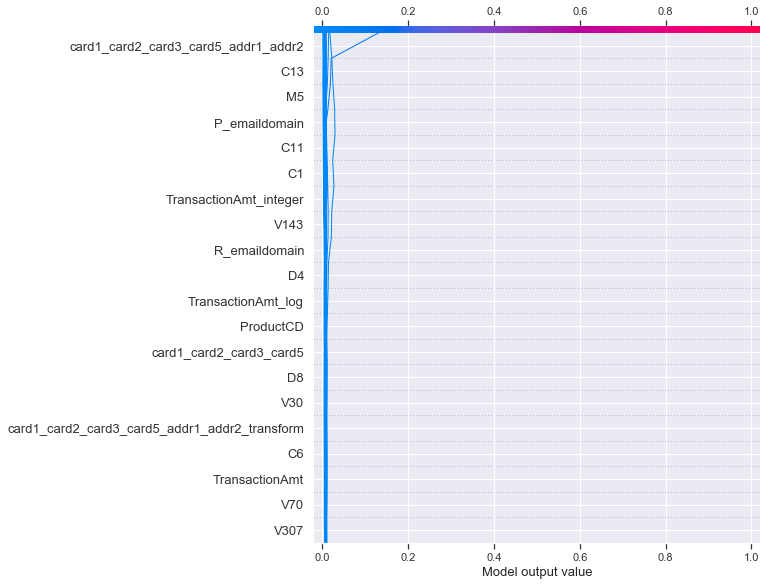

In [47]:
shap.decision_plot(expected_value, shap_values, features_display.iloc[:20], link="logit")

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


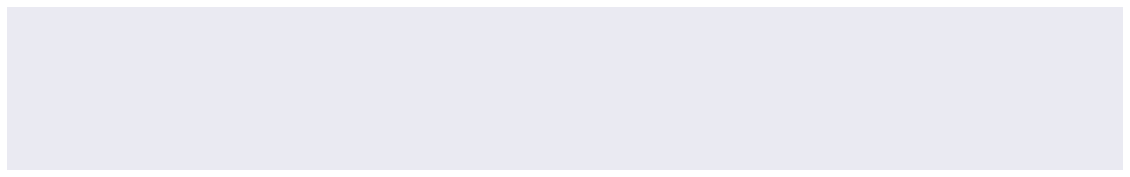

In [48]:
shap.force_plot(
    expected_value,
    shap_values[15],
    features_display.iloc[15],
    matplotlib=True,
    link='logit'
)

**Задание 4:** использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.

In [ ]:
from boostaroota import BoostARoota

In [ ]:
def prepare_data(X: pd.DataFrame) -> pd.DataFrame:
    """
    Подготовка набора данных для моделирования.
    Категориальные признаки преобразуются с помощью
    OneHotEnconding.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков.

    """
    categorical = X.dtypes[X.dtypes=="object"].index.tolist()

    X = pd.get_dummies(X, columns=categorical)
    X.columns = [col.lower() for col in X.columns]
    
    return X

In [ ]:
prepared_data = prepare_data(data)

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(
    prepared_data, target, train_size=0.7, shuffle=True, random_state=1,
)

In [ ]:
br = BoostARoota(metric='auc')
br.fit(x_train, y_train)

In [ ]:
br.keep_vars_

In [ ]:
x_train_br = br.transform(x_train)
x_valid_br = br.transform(x_valid)

dtrain_br = cb.Pool(x_train_br, y_train)
dvalid_br = cb.Pool(x_valid_br, y_valid)

In [ ]:
cb_params = {
#     "n_estimators": 3000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 100,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 100,
    "thread_count": 6,
    "random_seed": 42
}
model = cb.CatBoostClassifier(**cb_params)
fit_model = model.fit(dtrain_br, eval_set=[(dtrain_br), (dvalid_br)])

In [ ]:
model_br = xgb.train(
    params,
    dtrain_br,
    num_boost_round=5000,
    evals=[(dtrain_br, "train"), (dvalid_br, "valid")],
    early_stopping_rounds=50,
    verbose_eval=100
)

In [ ]:
old_preds = model.predict(dvalid)
new_preds = model_br.predict(dvalid_br)

old_score = roc_auc_score(y_valid, old_preds)
new_score = roc_auc_score(y_valid, new_preds)
print(f"Base XGBoost score = {round(old_score, 5)}")
print(f"Base BoostARoota score = {round(new_score, 5)}")